In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
import copy

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

/Users/ilyak/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int // self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

<H1>Часть первая: крестики-нолики при помощи Q-обучения</H1>

In [5]:
def estimate_reward(policy, env, cross, n_episodes=10000):
    rewards_sum = 0.

    for episode in range(n_episodes):
        trace = []
        state = env.reset()
        if not cross:
            state, reward, done, info = env.step(random.choice(state[1])) 
        while True:
            action = policy(state)

            state, reward, done, info = env.step(action)

            if not done:
                state, reward, done, info = env.step(random.choice(state[1])) 
            
            if not cross:
                reward = -reward
            
            if done:
                rewards_sum += reward
                break

    return rewards_sum / n_episodes


class policy_from_Q:
    def __init__(self, Q):
        self.Q = Q
    def __call__(self, state):
        env_hash, empty_spaces, cur_turn = state
        if env_hash not in self.Q:
            return random.choice(empty_spaces)
        else:
            return empty_spaces[np.argmax(self.Q[env_hash])]

In [4]:
def q_learn(env, cross, n_episodes=1000, estimate_step=0):
    Q = {}

    eps = .5
    gamma = 1.
    alpha = .1
    rewards_history = []
    
    for episode in range(n_episodes):
        if estimate_step and episode % estimate_step == 0:
            rewards_history.append(estimate_reward(policy_from_Q(Q), env, cross))
        
        env_hash, empty_spaces, cur_turn = env.reset()
        if not cross:
            (env_hash, empty_spaces, cur_turn), reward, done, info = env.step(random.choice(empty_spaces)) 
        
        while True:
            if env_hash not in Q:
                Q[env_hash] = np.zeros(len(empty_spaces))
            if random.random() < eps:
                action = random.randint(0, len(empty_spaces)-1)
            else:
                action = np.argmax(Q[env_hash])

            new_state, reward, done, info = env.step(empty_spaces[action])
            
            if not done:
                new_state, reward, done, info = env.step(random.choice(new_state[1]))
                if new_state[0] not in Q:
                    Q[new_state[0]] = np.zeros(len(new_state[1]))
            
            if not cross:
                reward = -reward
            
            if done:
                Q[env_hash][action] += alpha * (reward - Q[env_hash][action])
            else:
                Q[env_hash][action] += alpha * (reward + gamma * max(Q[new_state[0]]) - Q[env_hash][action])
            
            env_hash, empty_spaces, cur_turn = new_state
            
            if done:
                break
    
    return Q, rewards_history

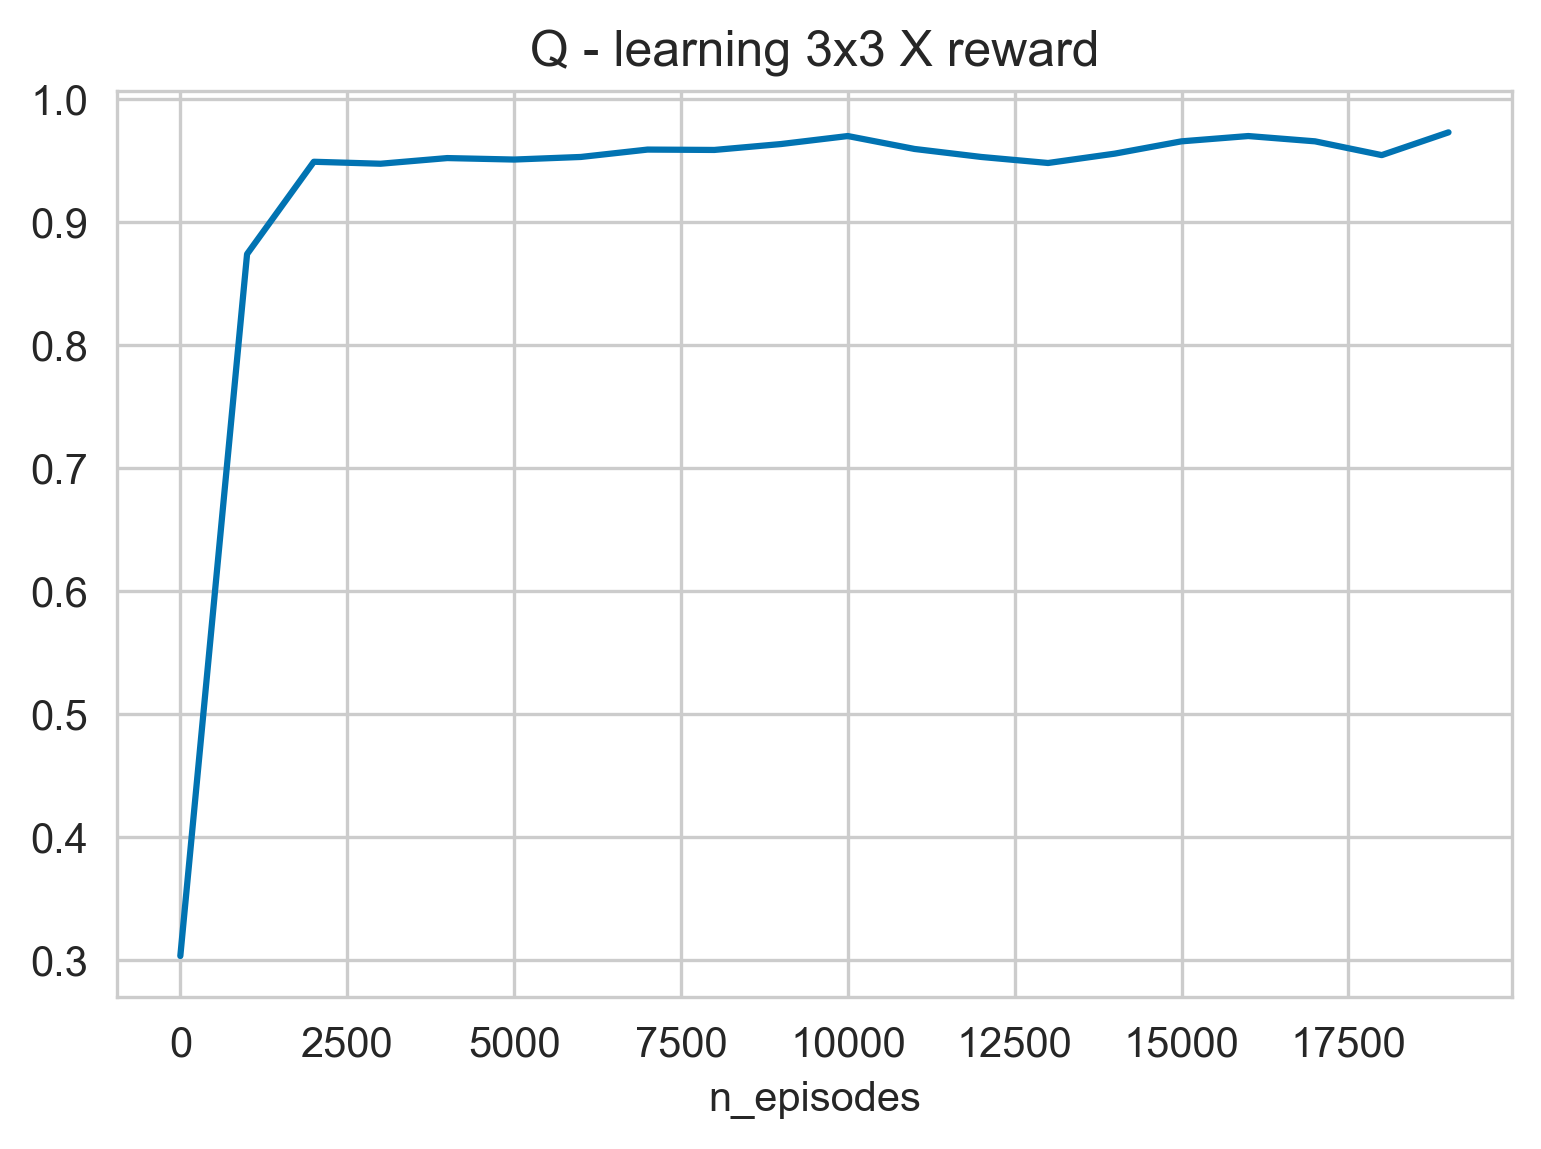

In [16]:
env = TicTacToe()
qpolicy3x3_x, rewards_history = q_learn(env, True, 20000, estimate_step=1000)
plt.title('Q - learning 3x3 X reward')
plt.xlabel('n_episodes')
plt.plot(range(0, 20000, 1000), rewards_history)

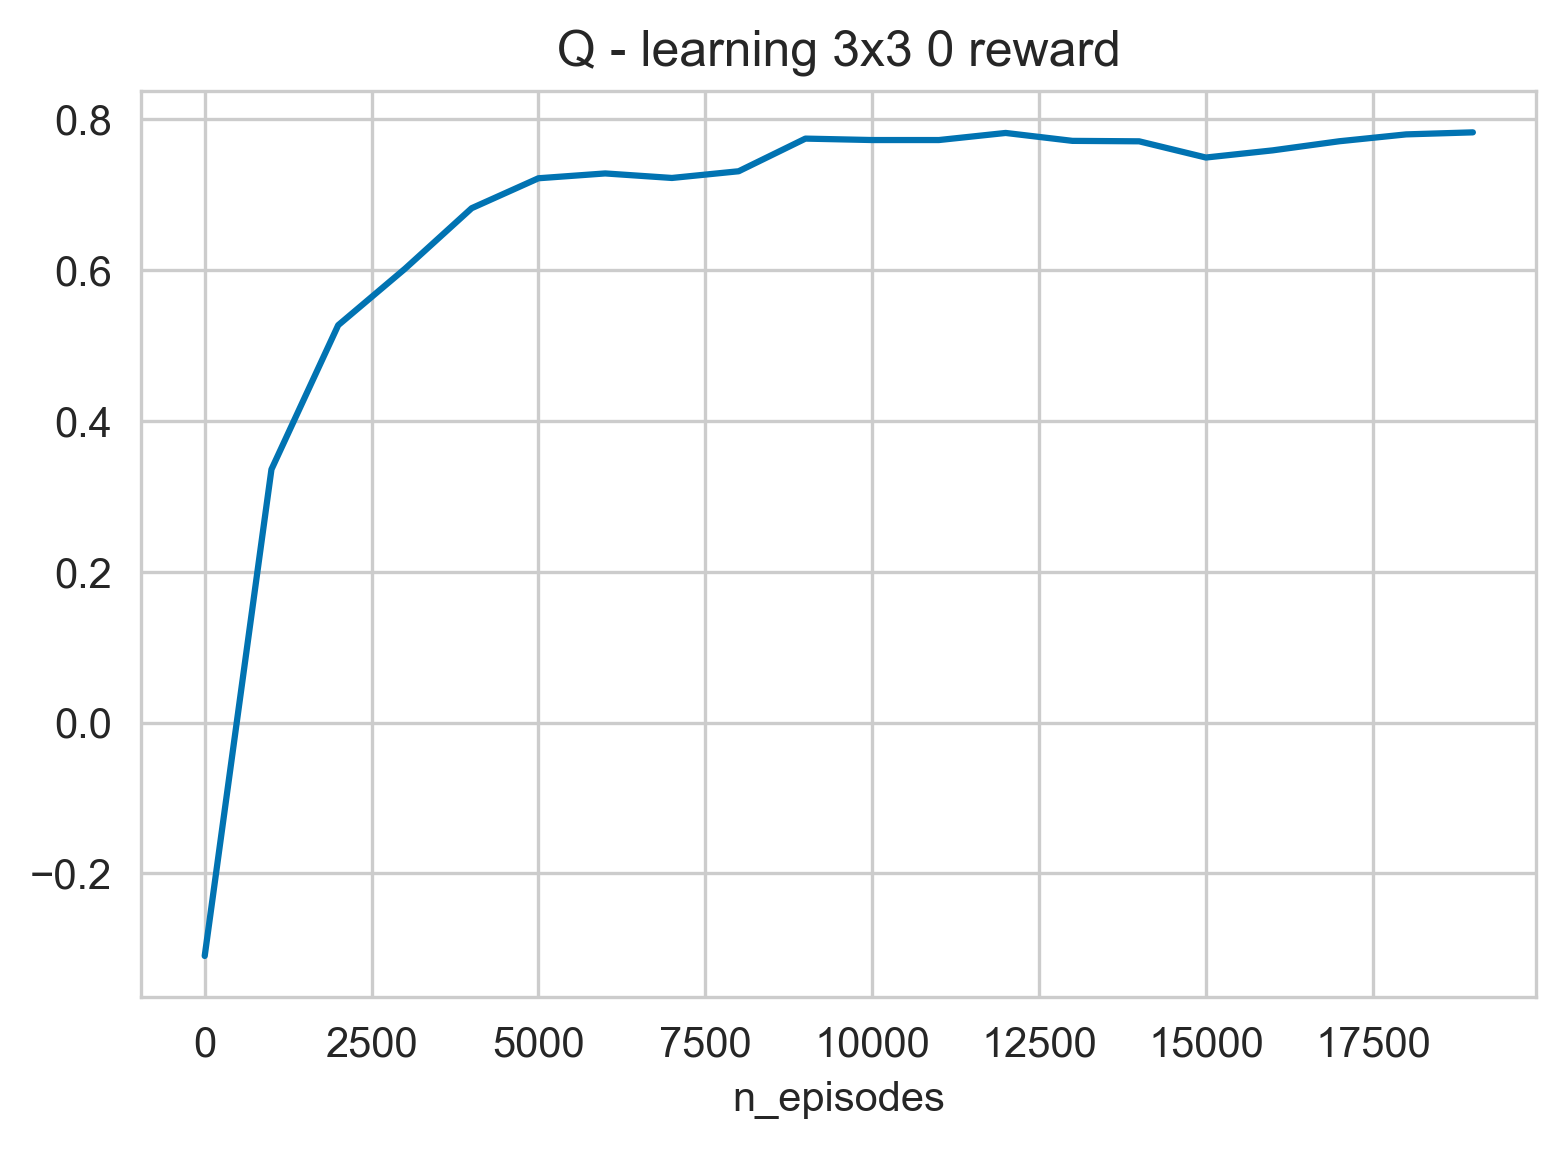

In [18]:
env = TicTacToe()
qpolicy3x3_0, rewards_history = q_learn(env, False, 20000, estimate_step=1000)
plt.title('Q - learning 3x3 0 reward')
plt.xlabel('n_episodes')
plt.plot(range(0, 20000, 1000), rewards_history)

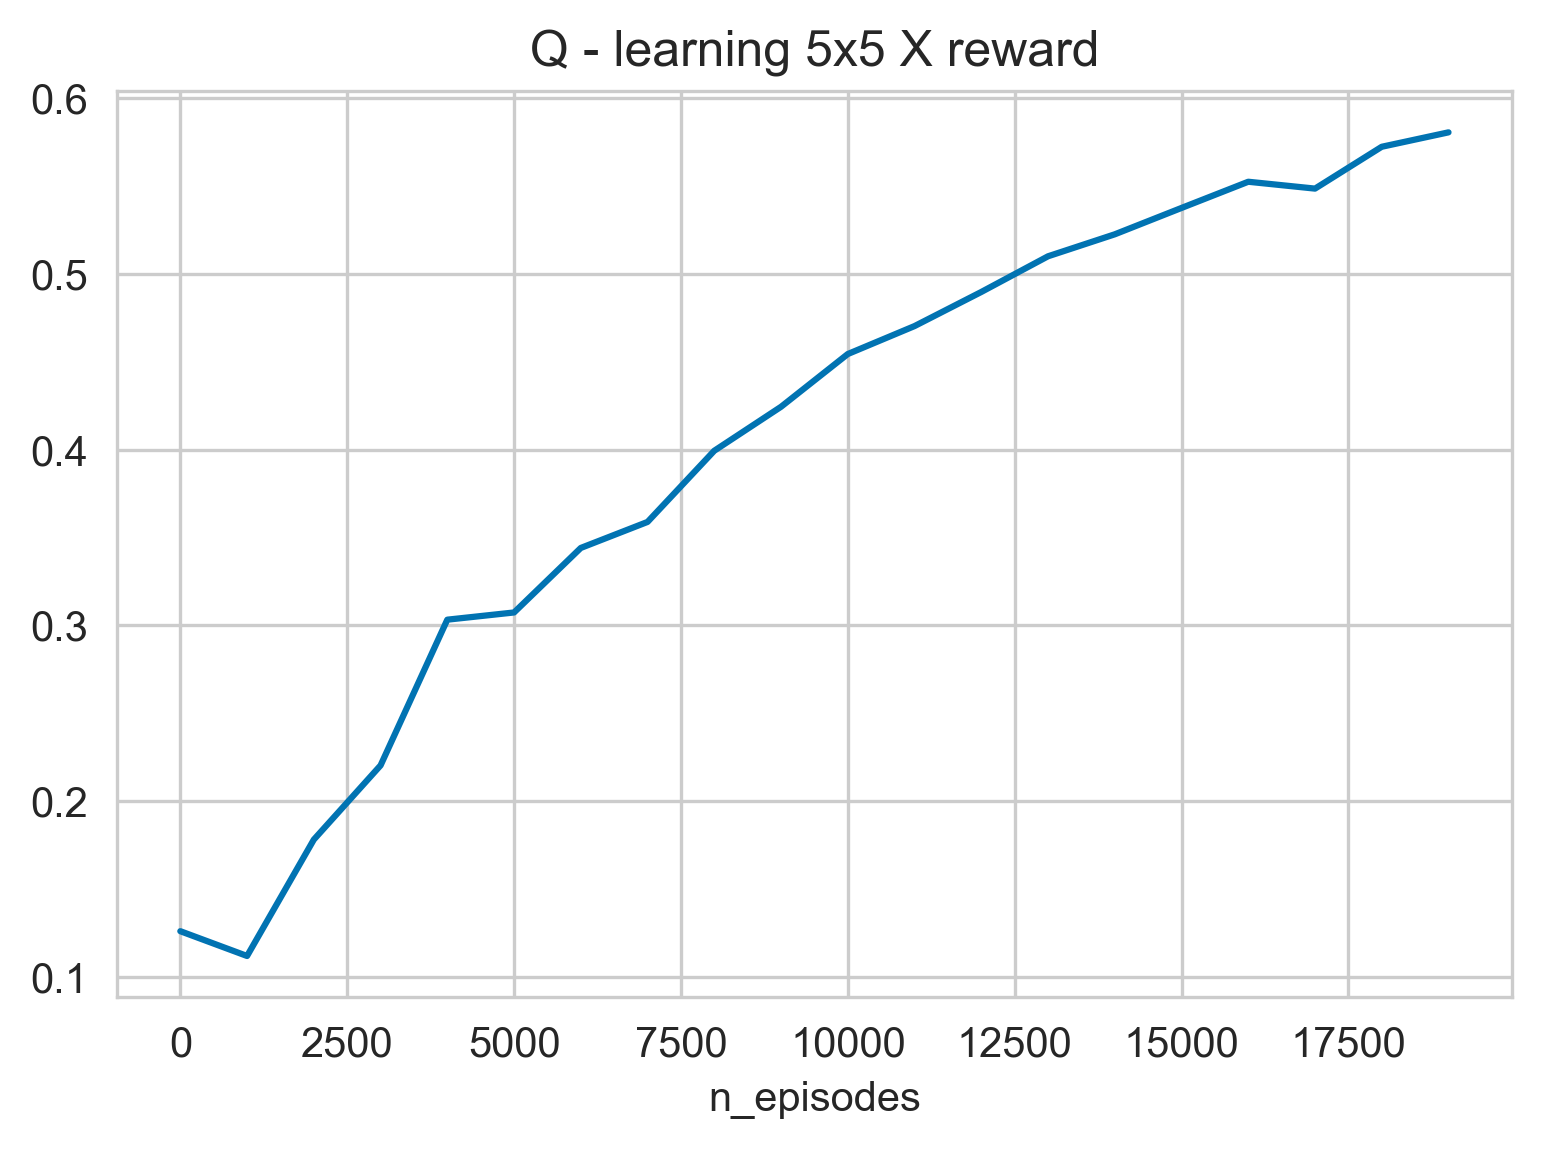

In [22]:
env = TicTacToe(5, 5, 4)
qpolicy5x5_x, rewards_history = q_learn(env, True, 20000, estimate_step=1000)
plt.title('Q - learning 5x5 X reward')
plt.xlabel('n_episodes')
plt.plot(range(0, 20000, 1000), rewards_history)

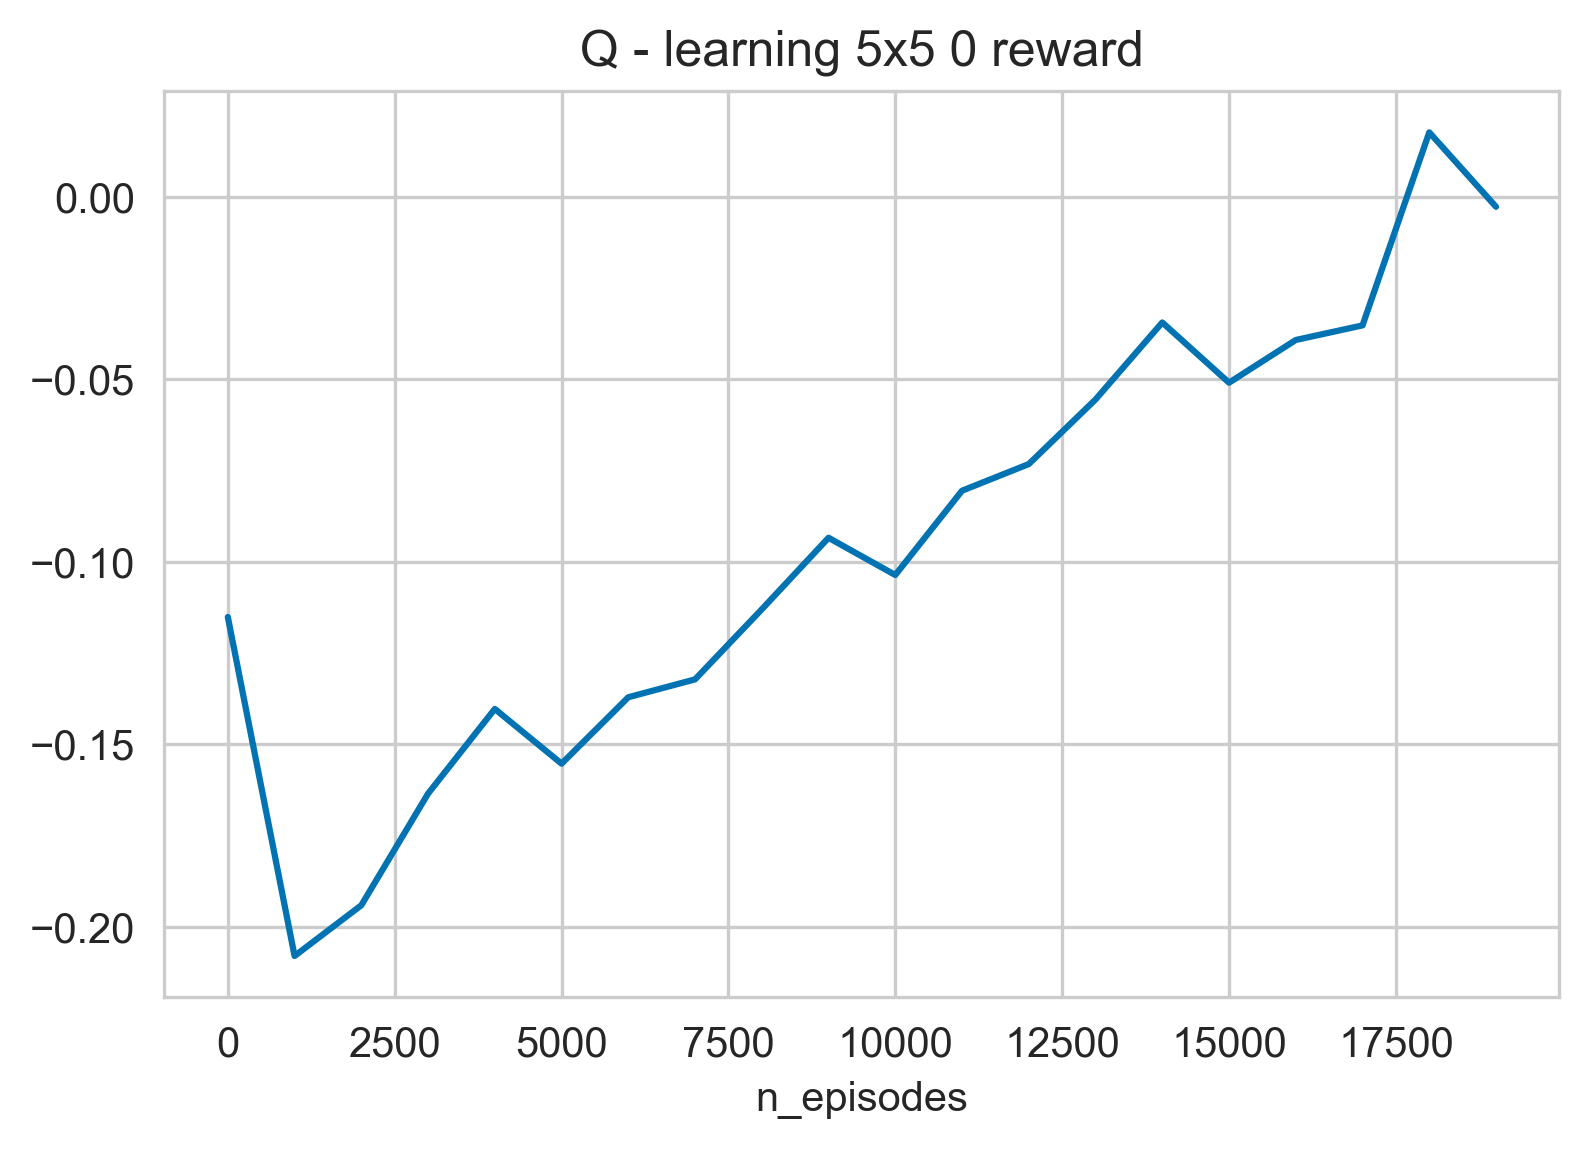

In [25]:
env = TicTacToe(5, 5, 4)
qpolicy5x5_x, rewards_history = q_learn(env, False, 20000, estimate_step=1000)
plt.title('Q - learning 5x5 0 reward')
plt.xlabel('n_episodes')
plt.plot(range(0, 20000, 1000), rewards_history)

<H1>Часть вторая: добавим нейронных сетей</H1>

In [37]:
class Network(nn.Module):
    def __init__(self, n_states):
        n_hidden = 10
        n_conv = 2
        nn.Module.__init__(self)
        self.net = nn.Sequential(
            nn.Conv2d(1, n_conv, kernel_size=3, padding=1),
            torch.nn.Flatten(), 
            nn.Linear(n_states * n_conv, n_hidden), 
            nn.ReLU(),
            nn.Linear(n_hidden, n_states)
        )

    def forward(self, x):
        q = self.net(x)
        q[x.view(q.shape)!=0] = -np.infty
        return q

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
  #      return self.memory
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    
class ToeDQN():
    def __init__(self, n_rows, n_cols, n_win, dueling=False):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.n_states = n_rows * n_cols
        if dueling:
            self.model = DuelingNetwork(self.n_states)
        else:
            self.model = Network(self.n_states)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        
        self.gamma = 0.8
        self.batch_size = 64
        
     #  self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
     #  self.num_step = 0        
    
    def select_action(self, board):
        sample = random.random()
     #   self.num_step += 1
     #   eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        eps_threshold = 0.5
        
        
        if sample > eps_threshold:
            return self.model(board).data[0].argmax()
        else:
            return random.choice(np.arange(self.n_states)[(board==0).flatten()])
        
    def run_episode(self, cross, greedy=False, render=False):
        state = self.env.reset()
        if not cross:
            state, reward, done, info = self.env.step(random.choice(state[1])) 
        
        while True:
            board = torch.tensor(self.env.board, dtype=torch.float32)[None,None,:,:]
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(board)
                else:
                    action = self.select_action(board)
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action))
            
            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(next_state[1]))

            if render:
                self.env.printBoard()    
            
            next_board = torch.tensor(self.env.board, dtype=torch.float32)[None,None,:,:]

            if not cross:
                reward = -reward
            
            transition = (board, action, next_board, reward)
            self.memory.store(transition)

            state = next_state

            if done:
                break

    def learn(self, episode_num):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action)[:,None]
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        
        Qmax = self.model(batch_next_state[batch_reward==0]).detach().max(1)[0]
        Qnext = batch_reward
        Qnext[batch_reward==0] += self.gamma * Qmax

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
    #    if episode_num % 100 == 0:
    #        print(episode_num, loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [42]:
#use board as state here
def estimate_reward_model(model, env, cross, n_episodes=2000):
    
    rewards_sum = 0.

    for episode in range(n_episodes):
        trace = []
        state = env.reset()
        if not cross:
            state, reward, done, info = env.step(random.choice(state[1])) 
        while True:
            board = torch.tensor(env.board, dtype=torch.float32)[None,None,:,:]
            action = env.action_from_int(model(board).data[0].argmax())
            
            state, reward, done, info = env.step(action)
            
            if not done:
                state, reward, done, info = env.step(random.choice(state[1])) 
            
            if not cross:
                reward = -reward
            
            if done:
                rewards_sum += reward
                break

                
    return rewards_sum / n_episodes

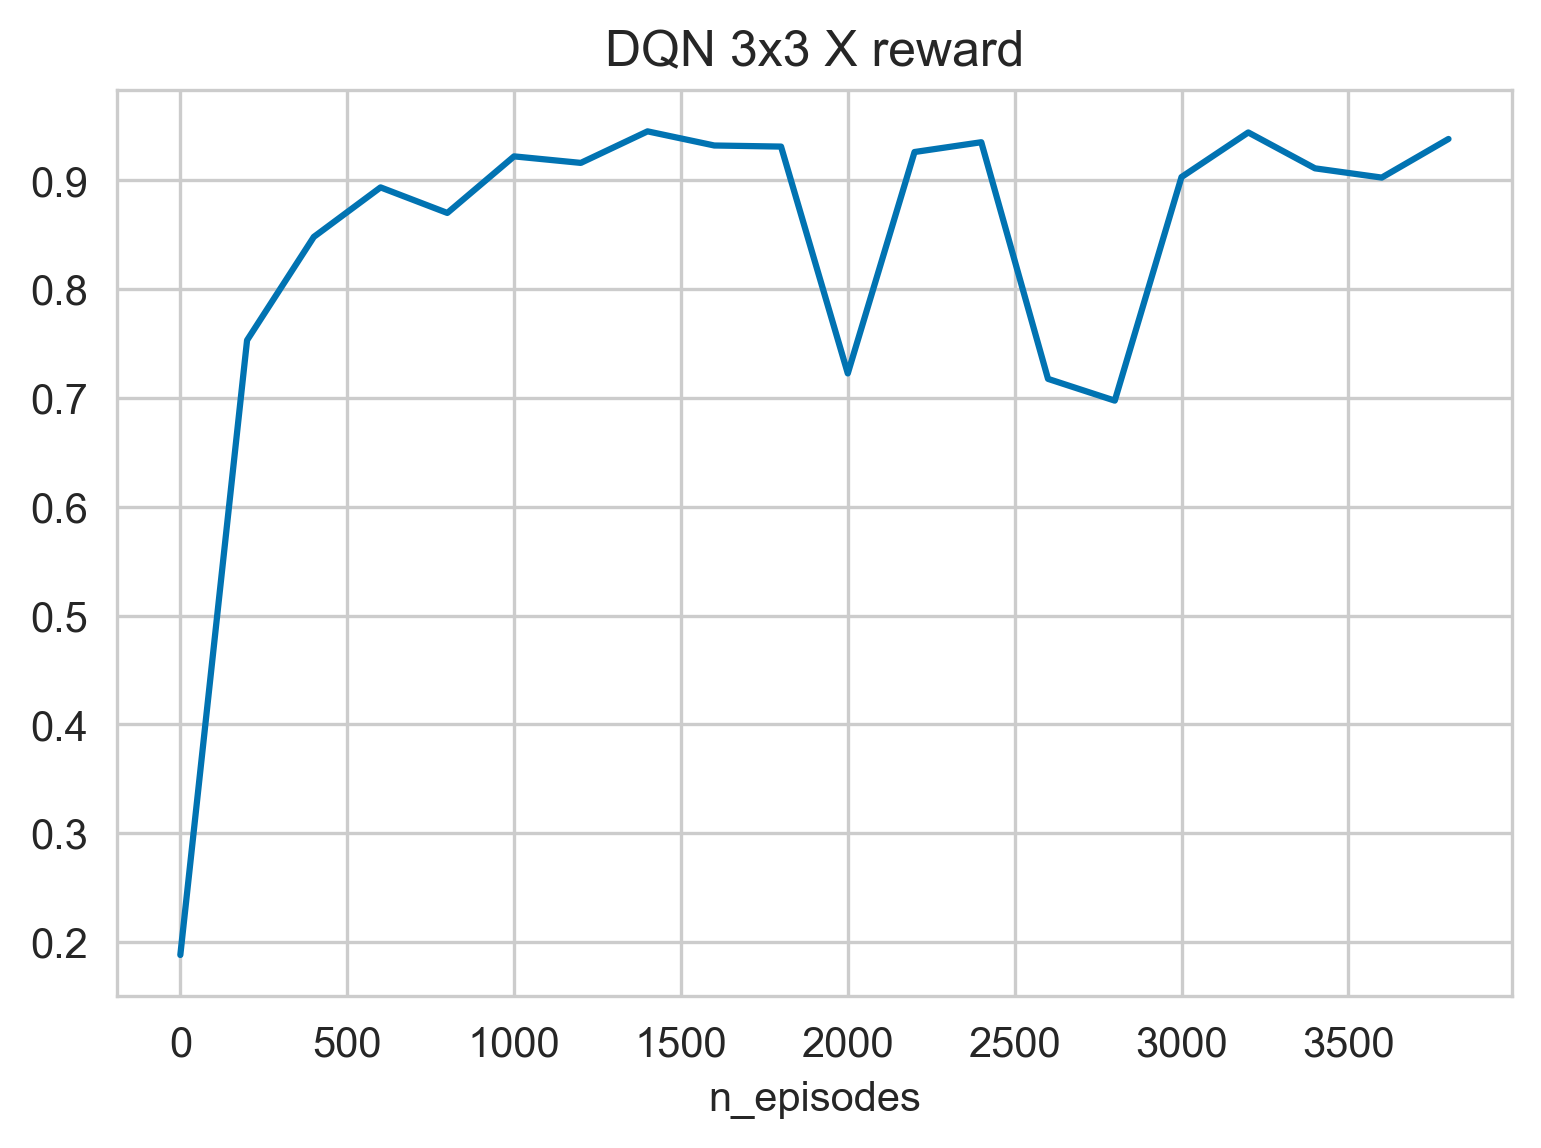

In [55]:
dqn = ToeDQN(3, 3, 3)

learn_history = []
for e in range(4000):
    dqn.run_episode(True)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, True)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('DQN 3x3 X reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

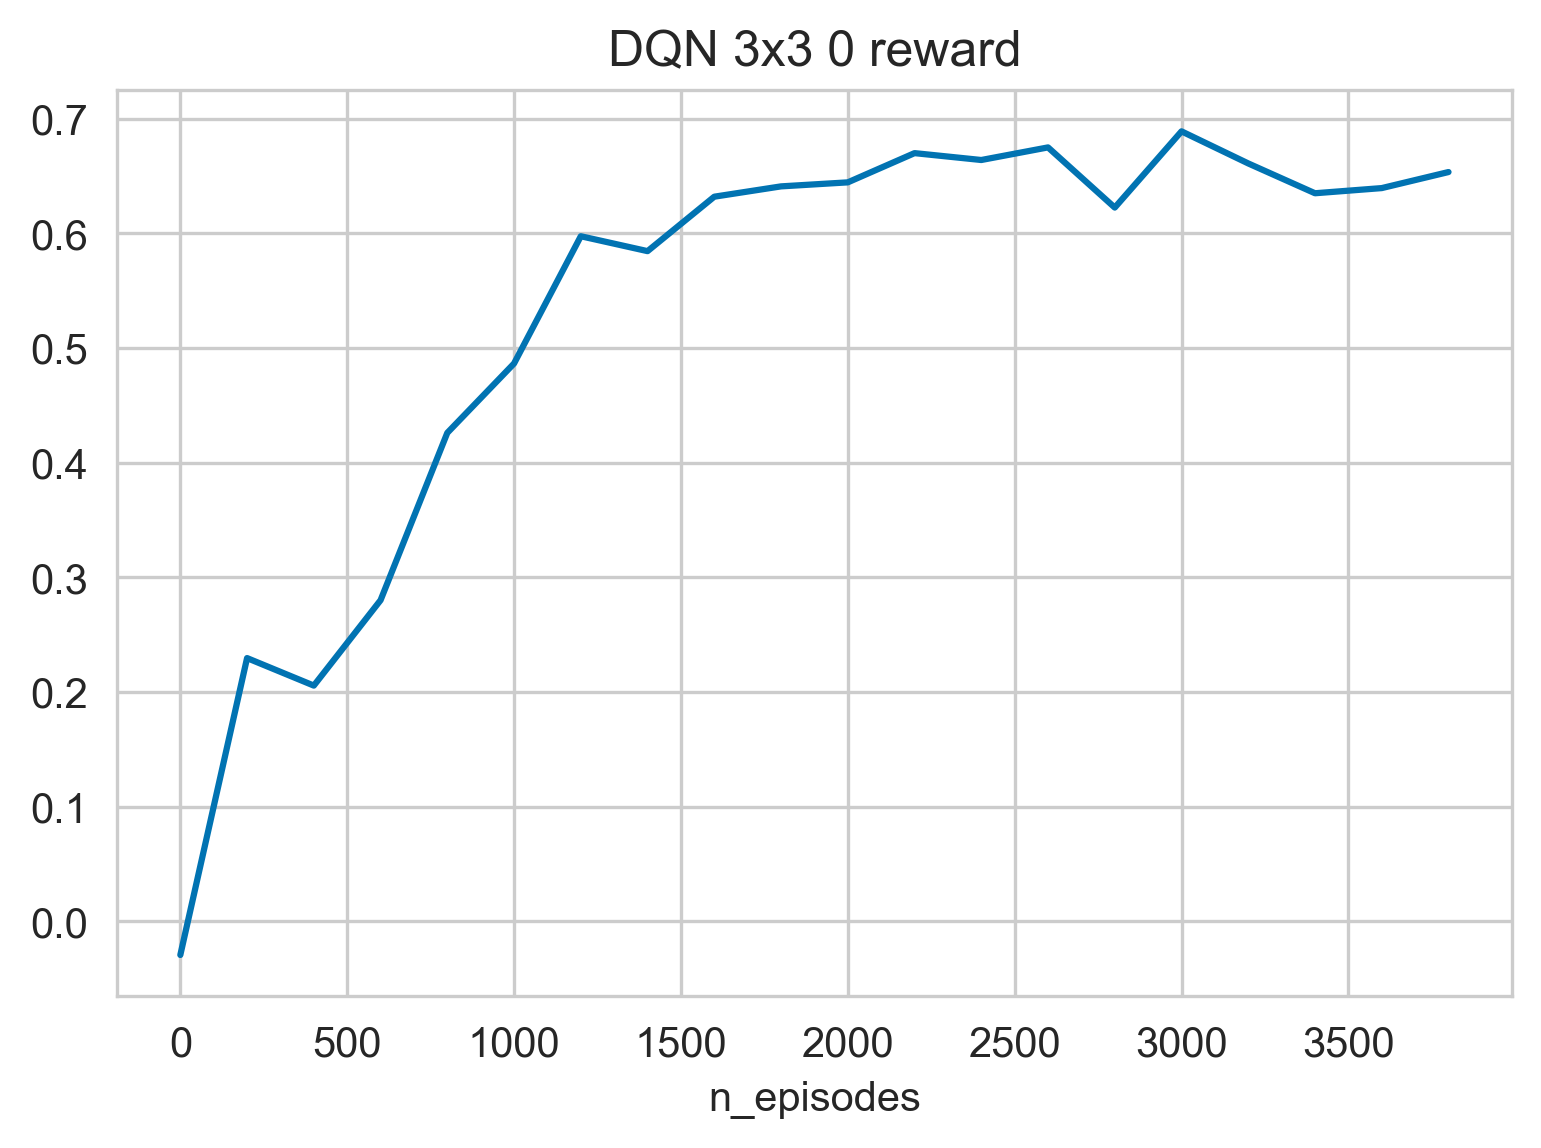

In [56]:
dqn = ToeDQN(3, 3, 3)

learn_history = []
for e in range(4000):
    dqn.run_episode(False)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, False)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('DQN 3x3 0 reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

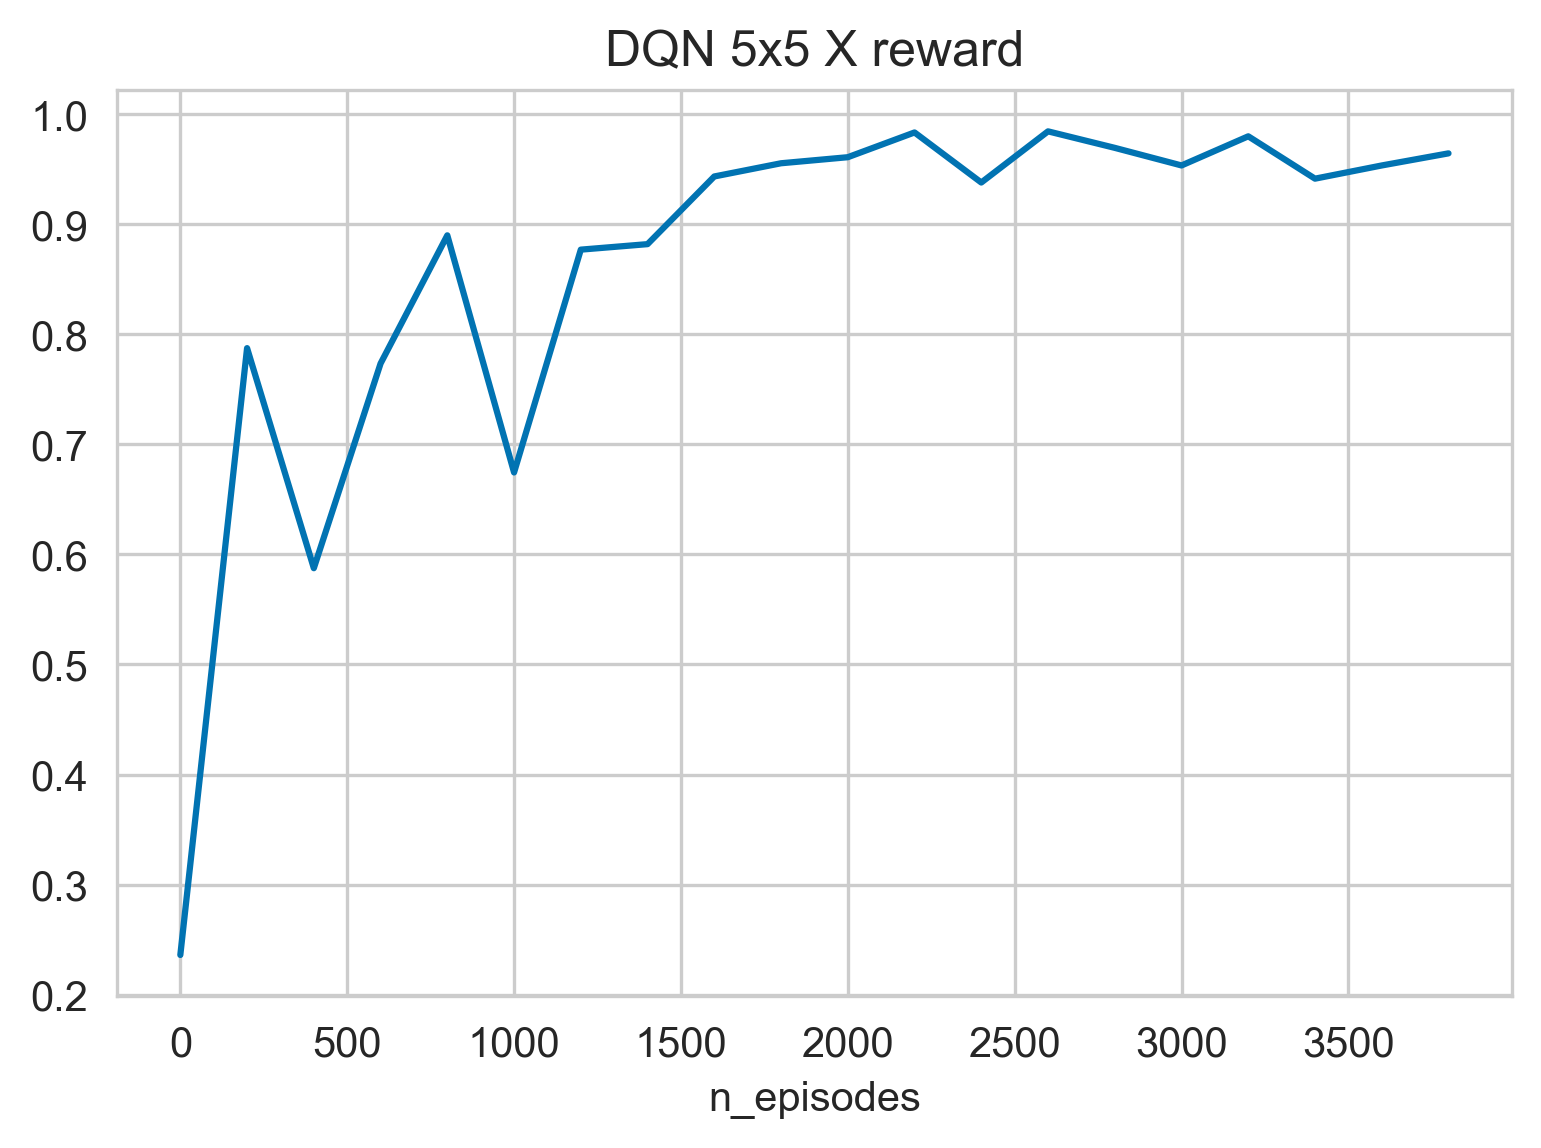

In [48]:
dqn = ToeDQN(5, 5, 4)

learn_history = []
for e in range(4000):
    dqn.run_episode(True)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, True)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('DQN 5x5 X reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

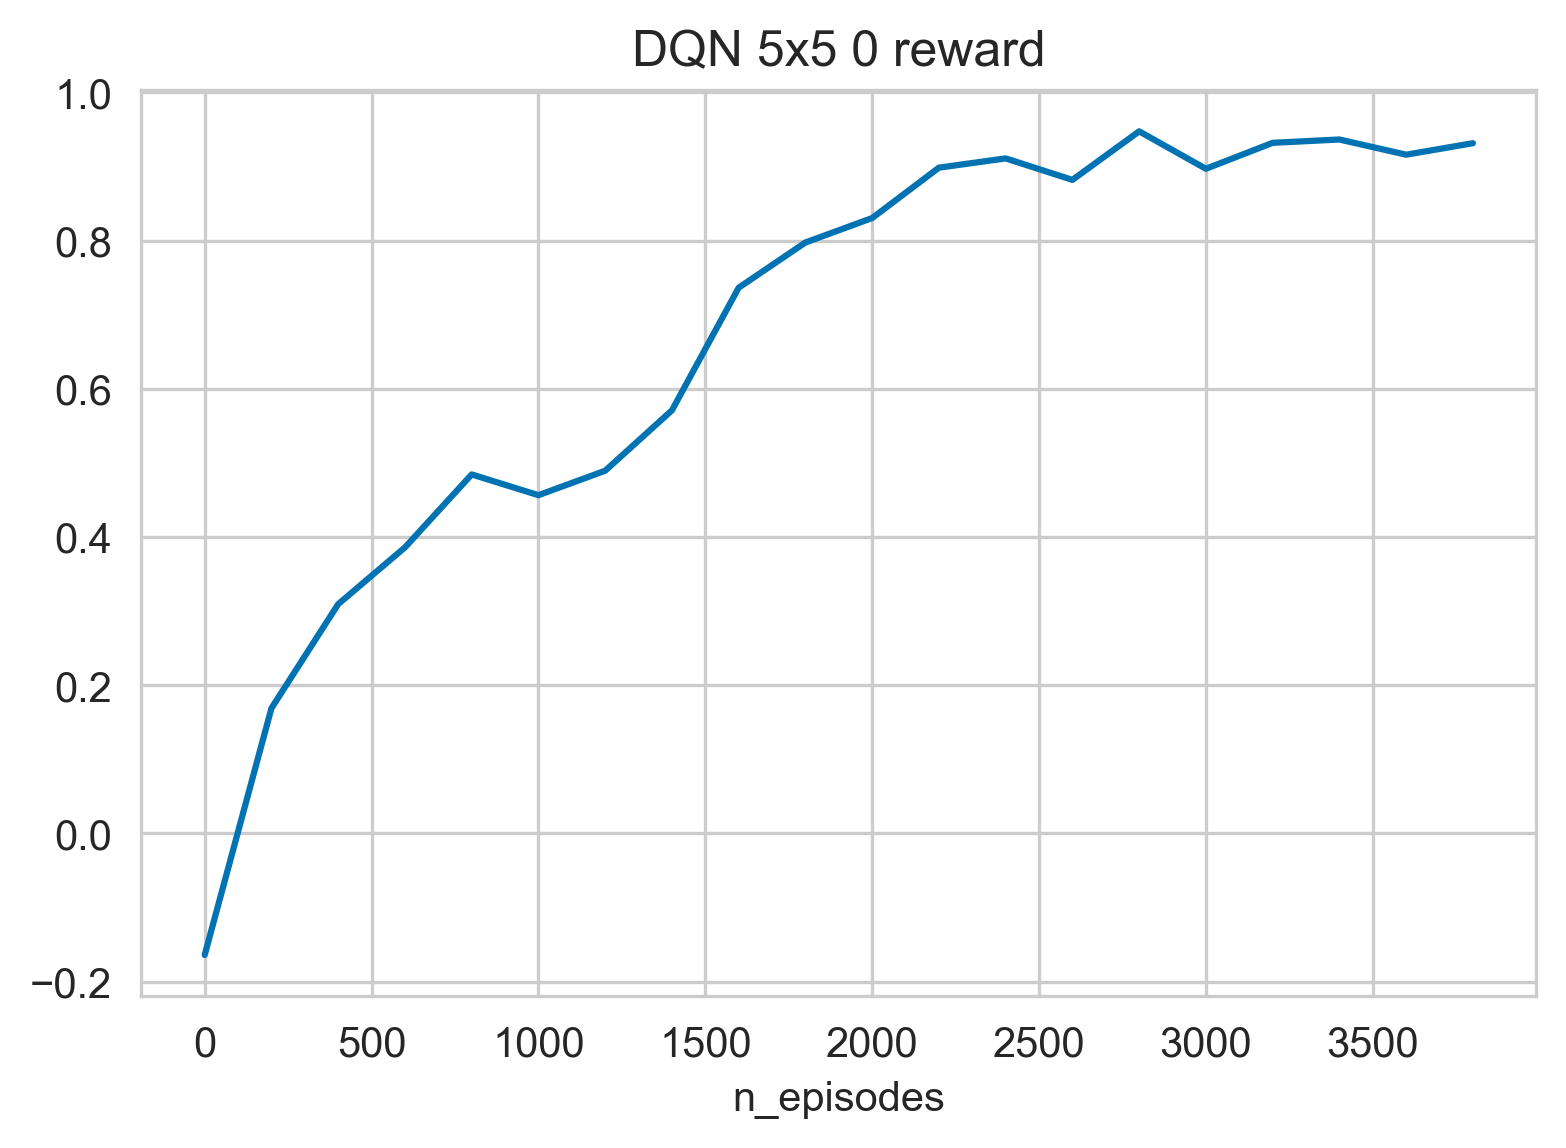

In [57]:
dqn = ToeDQN(5, 5, 4)

learn_history = []
for e in range(4000):
    dqn.run_episode(False)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, False)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('DQN 5x5 0 reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

In [61]:
class DoubleDQN():
    def __init__(self, n_rows, n_cols, n_win):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.n_states = n_rows * n_cols
        self.model = Network(self.n_states)
        self.target_model = Network(self.n_states)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        
        self.gamma = 0.8
        self.batch_size = 64
        
      #  self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
      #  self.num_step = 0        
    
    def select_action(self, board):
        sample = random.random()
      #  self.num_step += 1
       # eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        eps_threshold = 0.5
        
        
        if sample > eps_threshold:
            return self.model(board).data[0].argmax()
        else:
            return random.choice(np.arange(self.n_states)[(board==0).flatten()])
        
    def run_episode(self, cross, greedy=False, render=False):
        state = self.env.reset()
        if not cross:
            state, reward, done, info = self.env.step(random.choice(state[1])) 
        
        while True:
            board = torch.tensor(self.env.board, dtype=torch.float32)[None,None,:,:]
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(board)
                else:
                    action = self.select_action(board)
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action))
            
            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(next_state[1]))

            if render:
                self.env.printBoard()    
            
            next_board = torch.tensor(self.env.board, dtype=torch.float32)[None,None,:,:]

            if not cross:
                reward = -reward
            
            transition = (board, action, next_board, reward)
            self.memory.store(transition)

            state = next_state

            if done:
                break

    def learn(self, episode_num):
        network_sync_frequency = 200
        
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action)[:,None]
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).flatten()
        # оцениваем ожидаемые значения после этого действия
        
        amax = self.model(batch_next_state[batch_reward==0]).detach().max(1)[1][:,None]
        Qmax = torch.gather(self.target_model(batch_next_state[batch_reward==0]).detach(), 1, amax).flatten()
        
        Qnext = batch_reward
        Qnext[batch_reward==0] += self.gamma * Qmax

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
    #    if episode_num % 100 == 0:
    #        print(episode_num, loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if episode_num % network_sync_frequency == 0:
            self.target_model.load_state_dict(self.model.state_dict())
            

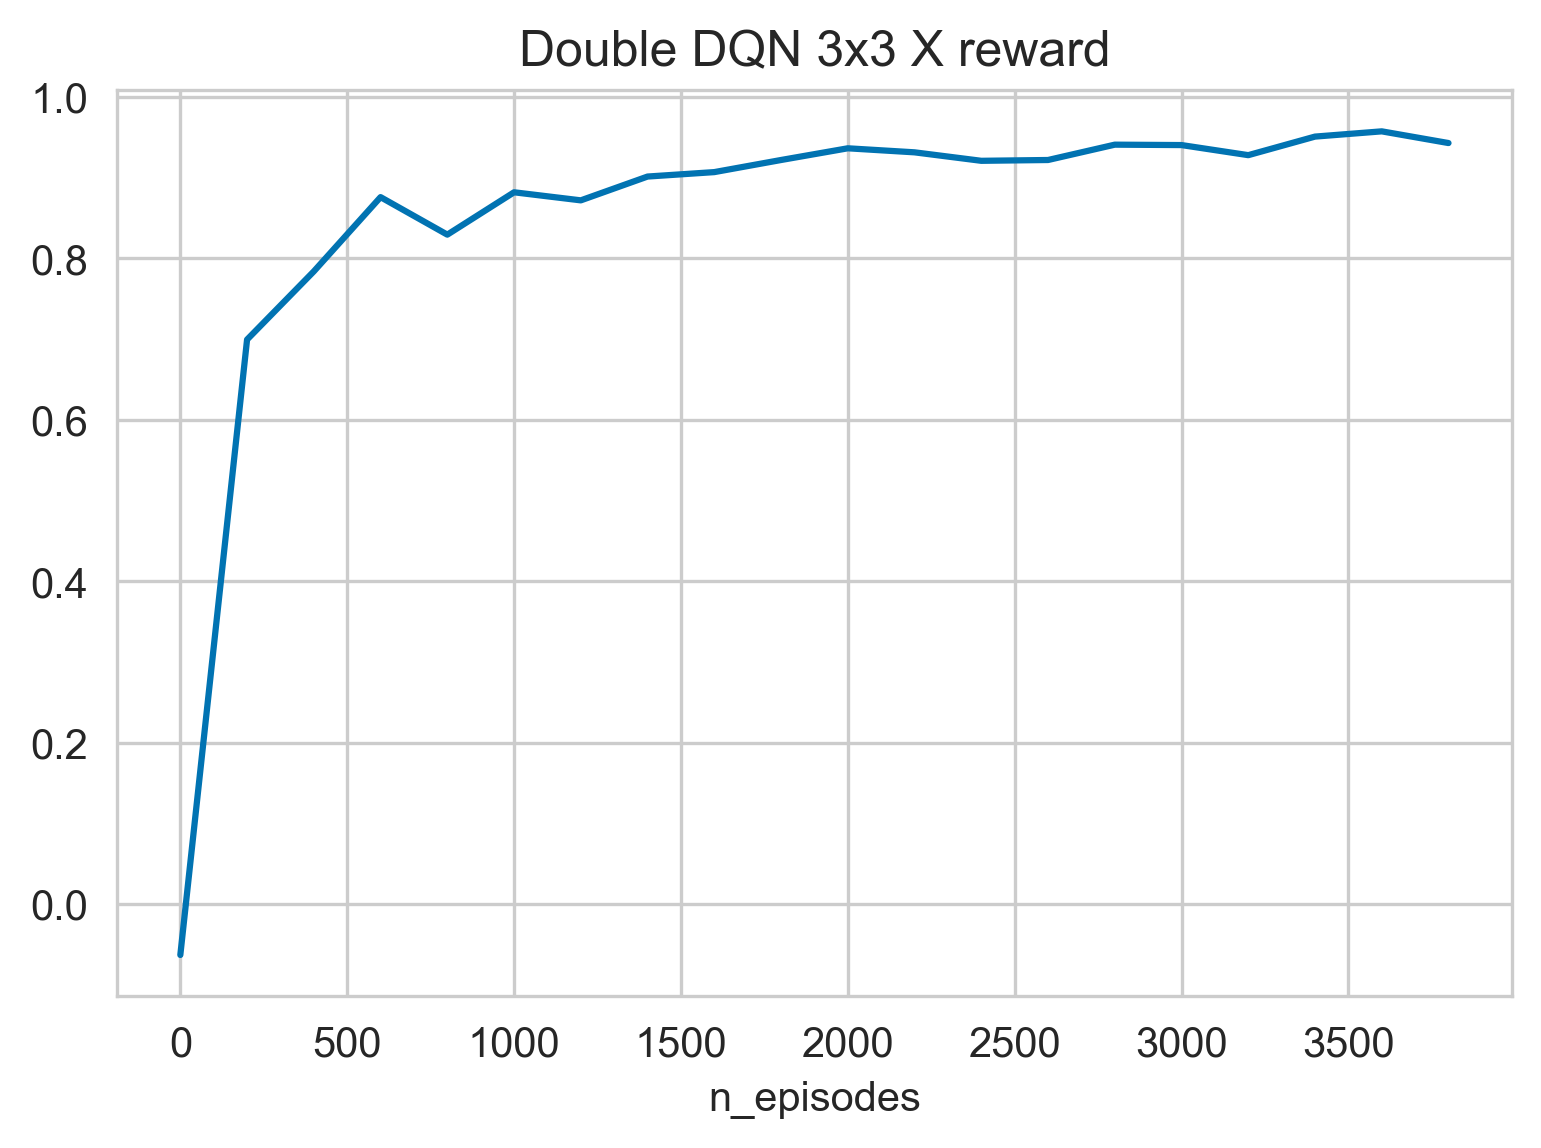

In [62]:
dqn = DoubleDQN(3, 3, 3)
learn_history = []
for e in range(4000):
    dqn.run_episode(True)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, True)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Double DQN 3x3 X reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

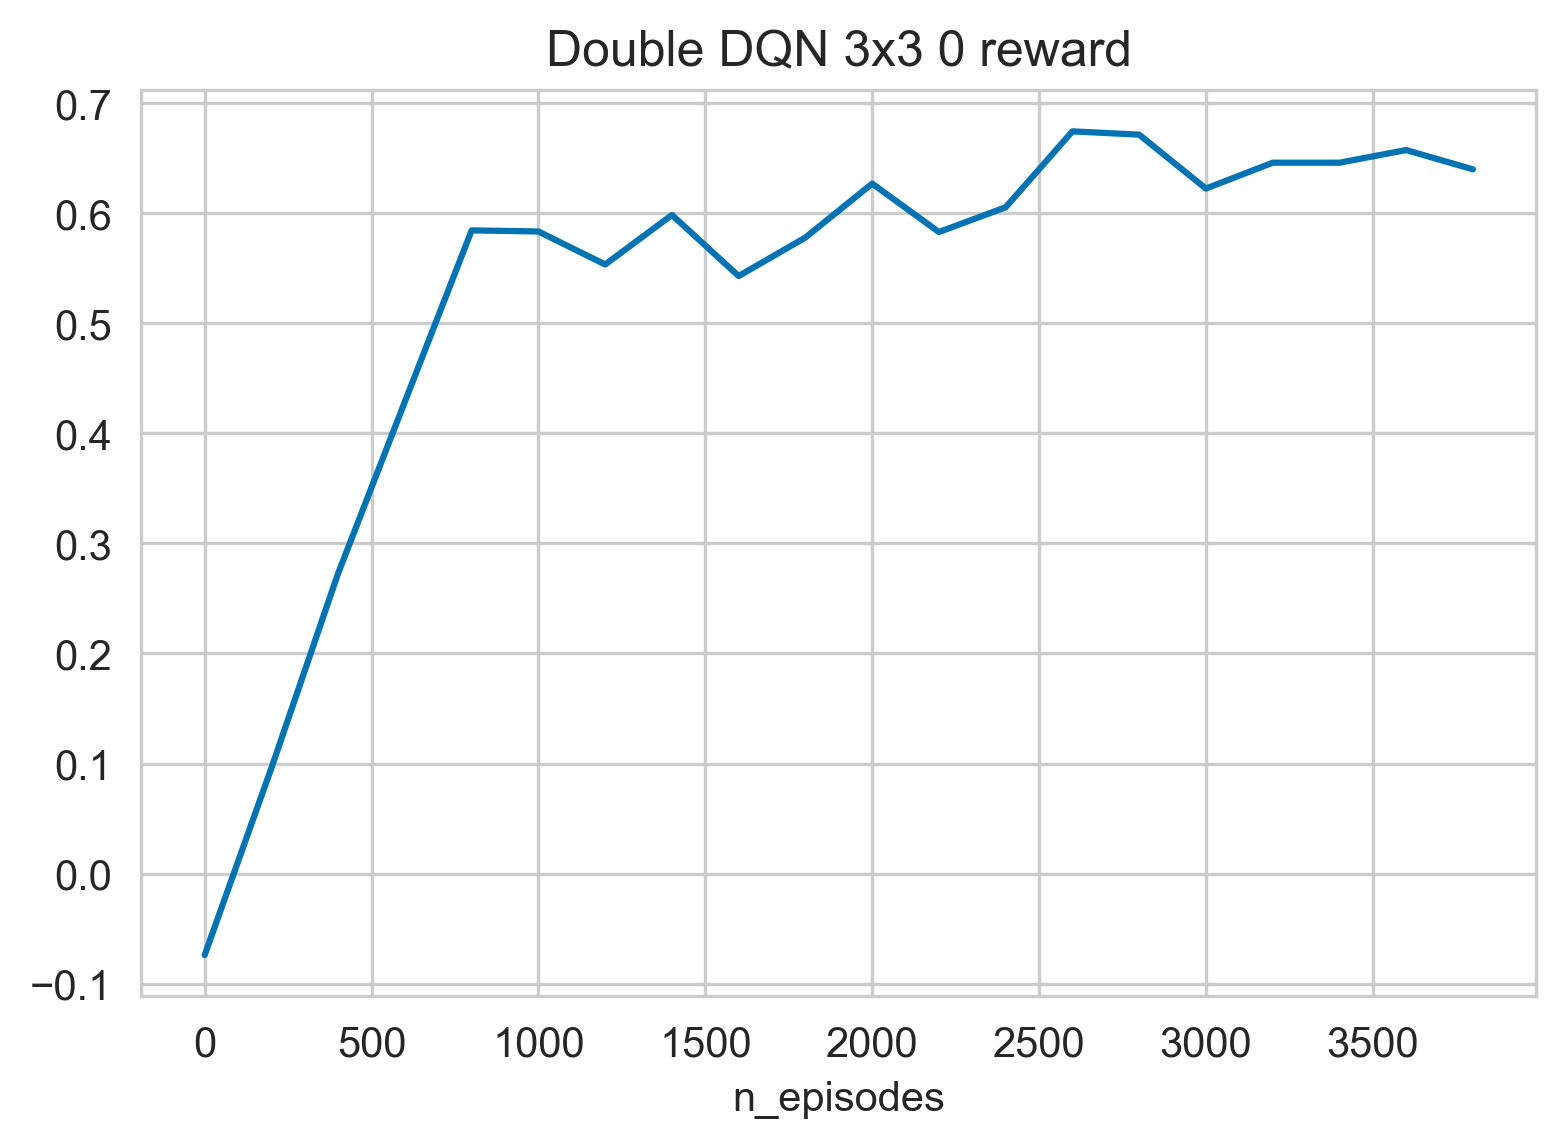

In [64]:
dqn = DoubleDQN(3, 3, 3)
learn_history = []
for e in range(4000):
    dqn.run_episode(False)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, False)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Double DQN 3x3 0 reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

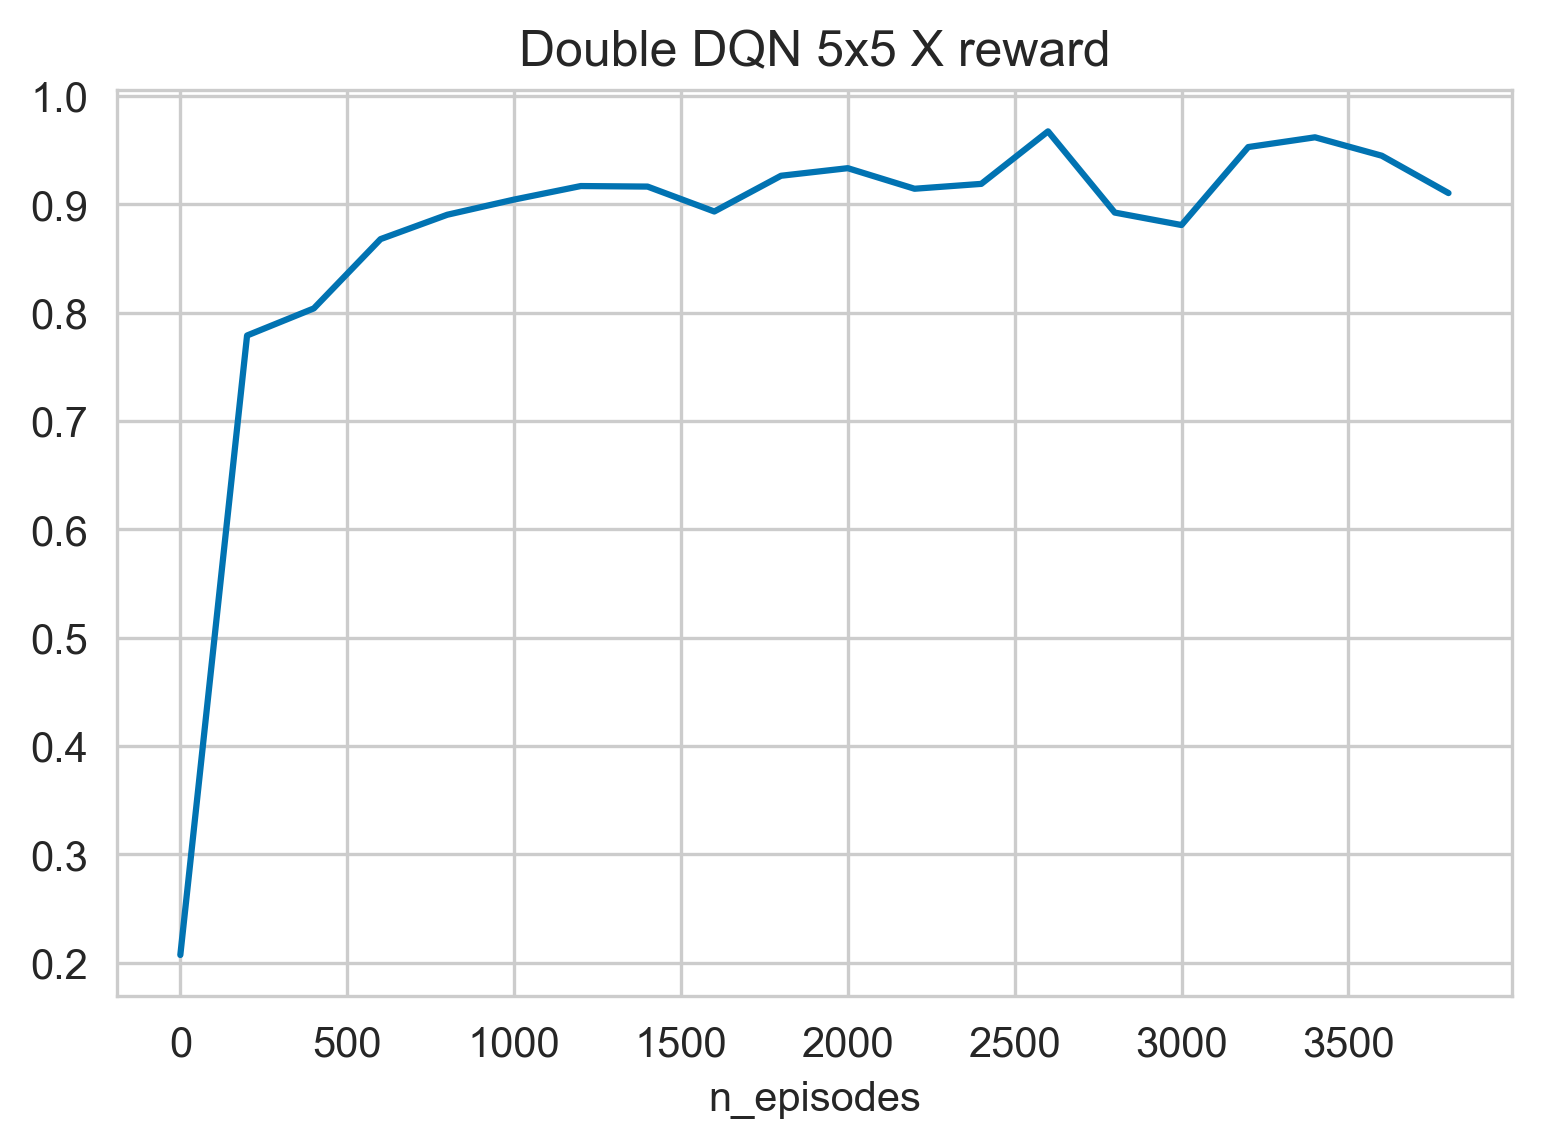

In [65]:
dqn = DoubleDQN(5, 5, 4)
learn_history = []
for e in range(4000):
    dqn.run_episode(True)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, True)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Double DQN 5x5 X reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

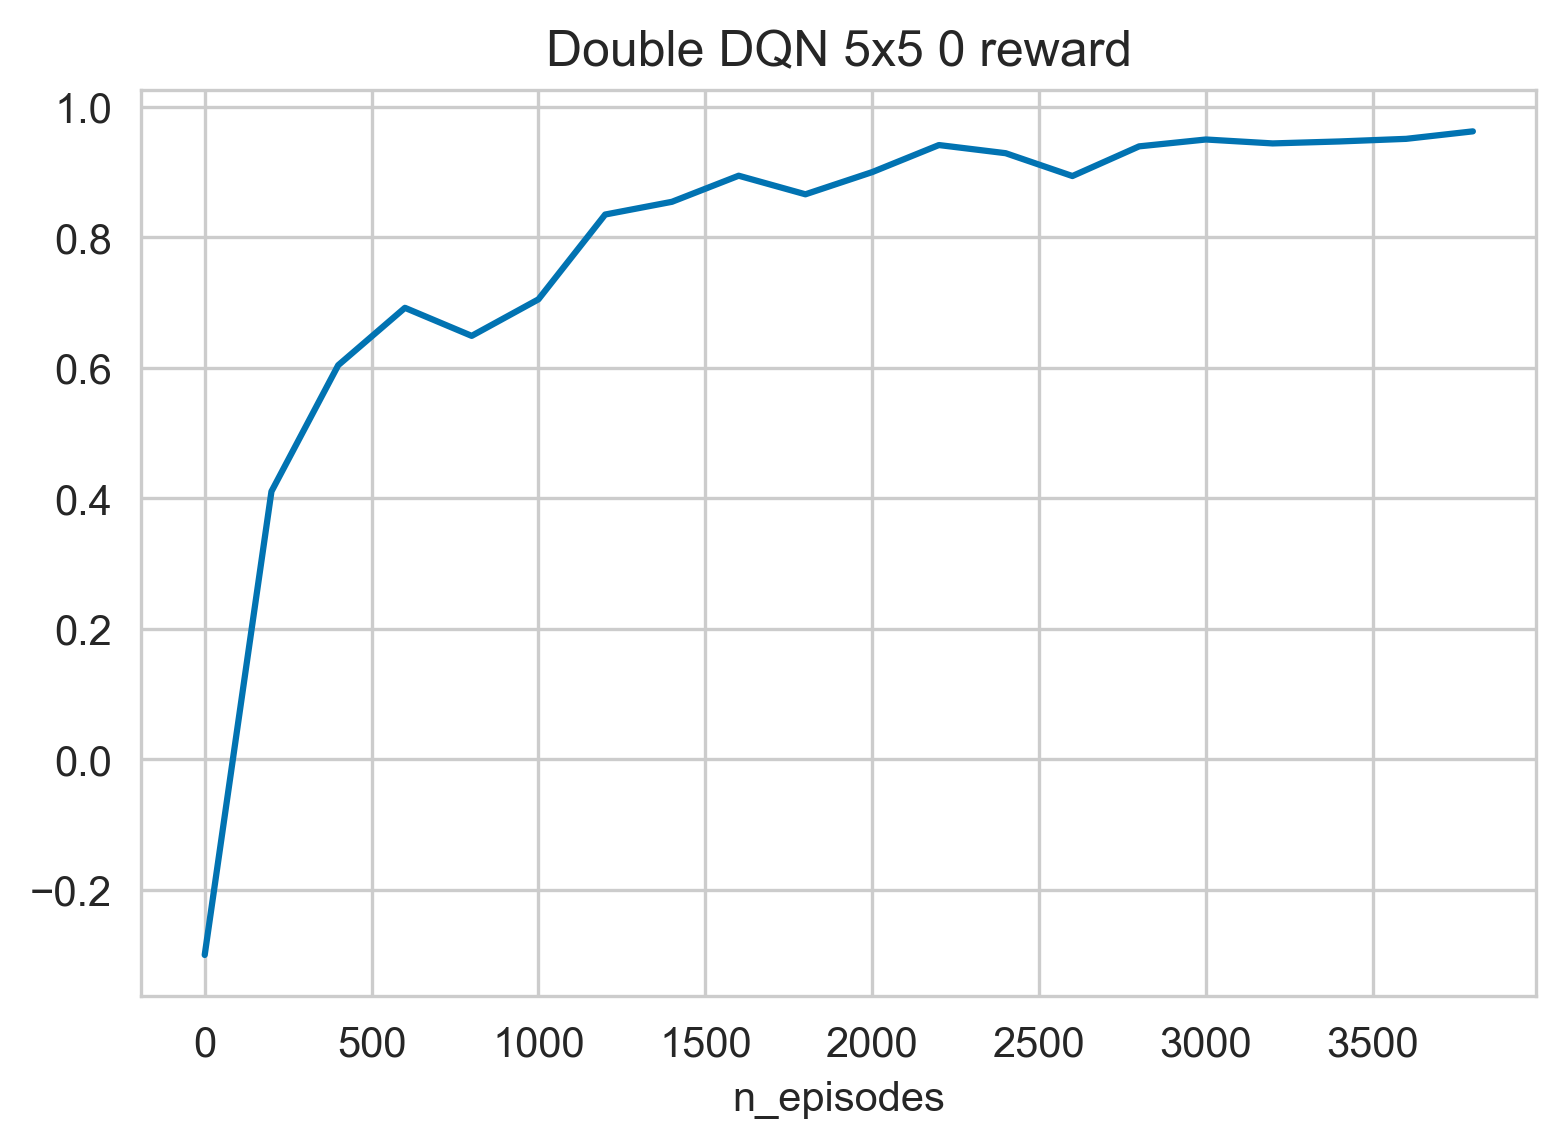

In [66]:
dqn = DoubleDQN(5, 5, 4)
learn_history = []
for e in range(4000):
    dqn.run_episode(False)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, False)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Double DQN 5x5 0 reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

In [67]:
class DuelingNetwork(nn.Module):
    def __init__(self, n_states):
        n_hidden = 10
        n_conv = 2
        nn.Module.__init__(self)
        self.features_net = nn.Sequential(
            nn.Conv2d(1, n_conv, kernel_size=3, padding=1),
            torch.nn.Flatten(), 
            nn.Linear(n_states * n_conv, n_hidden), 
            nn.ReLU(),
        )
        
        self.values_net = nn.Sequential(
            nn.Linear(n_hidden, 1)
        )
        
        self.advantage_net = nn.Sequential(
            nn.Linear(n_hidden, n_states)
        )

    def forward(self, x):
        features = self.features_net(x)
        values = self.values_net(features)
        advantage = self.advantage_net(features)
        q = values + (advantage - advantage.mean())
        q[x.view(q.shape)!=0] = -np.infty
        return q

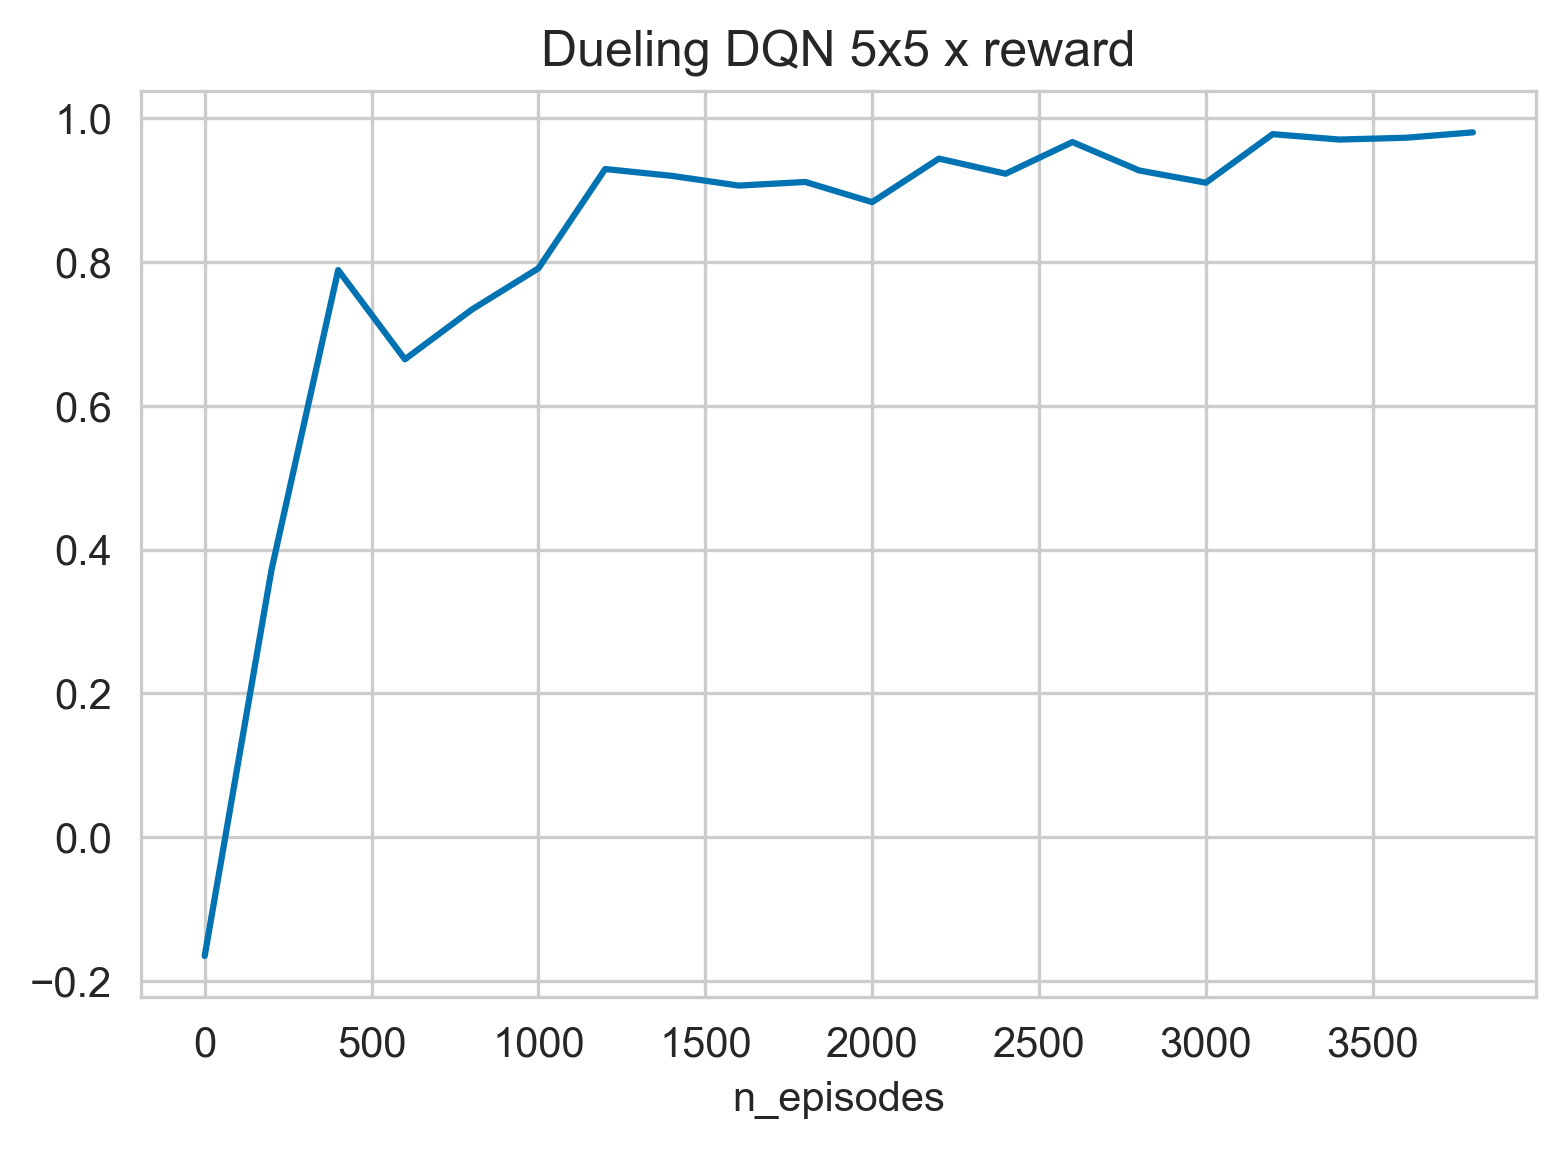

In [68]:
dqn = ToeDQN(5, 5, 4, dueling=True)

learn_history = []
for e in range(4000):
    dqn.run_episode(True)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, True)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Dueling DQN 5x5 x reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

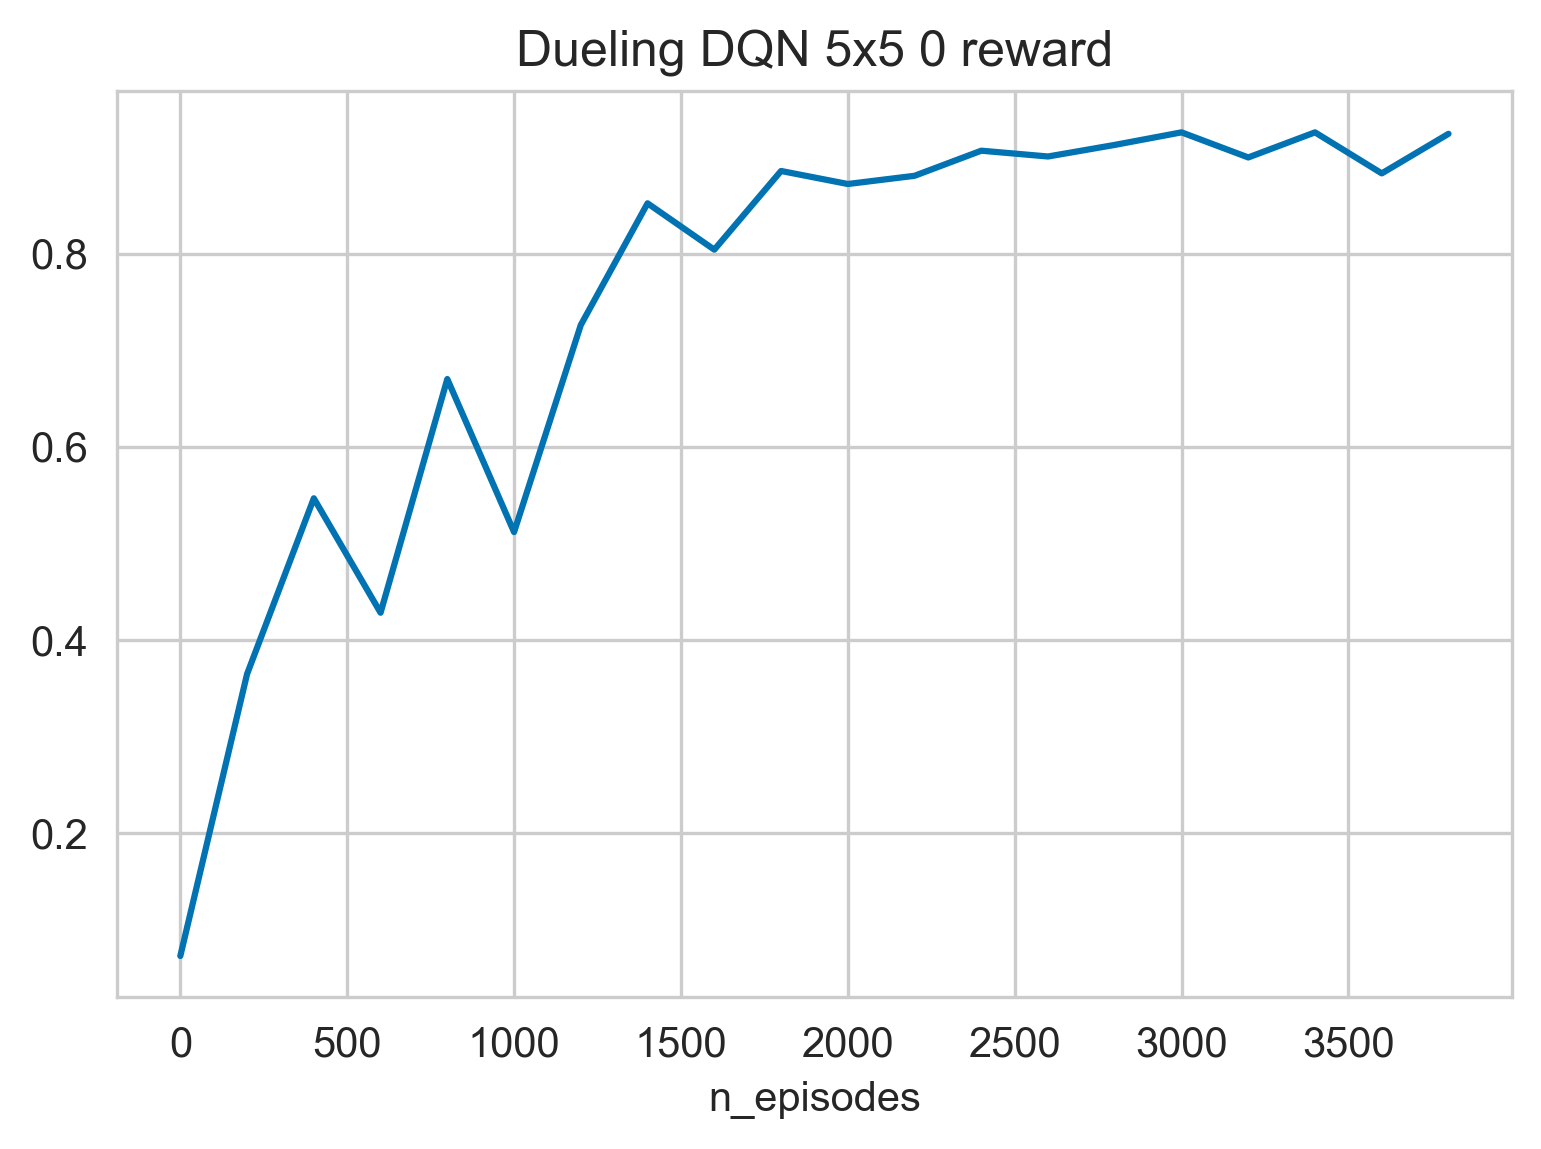

In [69]:
dqn = ToeDQN(5, 5, 4, dueling=True)

learn_history = []
for e in range(4000):
    dqn.run_episode(False)
    ToeDQN.learn(dqn, e)
    if e % 200 == 0:
        learn_history.append((e, estimate_reward_model(dqn.model, dqn.env, False)))
        # print(e, estimate_reward_model(dqn.model, dqn.env, False))
    
plt.title('Dueling DQN 5x5 0 reward')
plt.xlabel('n_episodes')
plt.plot(*list(zip(*learn_history)))

<H1>Часть третья: расширим и углубим поиск</H1>

In [6]:
def rollout(env, policy1, policy2):
    state = env.getState()
 #   env.printBoard()
    while True:
        if policy1:
            action = policy1(state)
        else:
            action = random.choice(state[1])

        state, reward, done, info = env.step(action)
      #  env.printBoard()
        if done:
            return reward
        
        if policy2:
            action = policy2(state)
        else:
            action = random.choice(state[1])
        
        state, reward, done, info = env.step(action)
       # env.printBoard()

        if done:
            return reward

def rollout_policy(cross, base_policy):
    def policy(env):
        games_per_action = 10
        state = env.getState()
        rewards_sum = np.zeros(len(state[1]))
        for action_idx, action in enumerate(state[1]):
            action_env = copy.deepcopy(env)
            action_state, action_reward, action_done, _ = action_env.step(action)
            if action_done:
                rewards_sum[action_idx] = games_per_action * action_reward

            else:
                for game_no in range(games_per_action):
                    game_reward = rollout(copy.deepcopy(action_env), base_policy, None)
                    rewards_sum[action_idx] += game_reward
                    
        if not cross:
            rewards_sum = -rewards_sum

        return state[1][np.argmax(rewards_sum)]
    return policy

def play_rollouts(cross, policy, env):
    state = env.reset()
    
    if not cross:
        state, reward, done, info = env.step(random.choice(state[1])) 
    
    while True:
        action = policy(env)
            
        state, reward, done, info = env.step(action)
    
        if not done:
            state, reward, done, info = env.step(random.choice(state[1]))
           # env.printBoard()
                
        if done:
           # env.printBoard()
            return reward if cross else -reward

In [89]:
env = TicTacToe(3, 3, 3)
rollout_policyx = rollout_policy(True, None)
print('Rollout random policy 3x3 X reward:')
np.mean([play_rollouts(True, rollout_policyx, env) for game_no in range(1000)])

Rollout random policy 3x3 X reward:


0.963

In [90]:
rollout_policy0 = rollout_policy(False, None)
print('Rollout random policy 3x3 0 reward:')
np.mean([play_rollouts(False, rollout_policy0, env) for game_no in range(1000)])

Rollout random policy 3x3 0 reward:


0.757

In [103]:
env = TicTacToe(5, 5, 4)
rollout_policyx = rollout_policy(True, None)
print('Rollout random policy 5x5 X reward:')
np.mean([play_rollouts(True, rollout_policyx, env) for game_no in range(100)])

Rollout random policy 5x5 X reward:


0.96

In [106]:
env = TicTacToe(5, 5, 4)
rollout_policyx = rollout_policy(False, None)
print('Rollout random policy 5x5 0 reward:')
np.mean([play_rollouts(False, rollout_policyx, env) for game_no in range(100)])

Rollout random policy 5x5 0 reward:


0.98

In [91]:
rollout_polcyx_q = rollout_policy(True, policy_from_Q(qpolicy3x3_x))
print('Rollout with Q-policy 3x3 X reward:')
np.mean([play_rollouts(True, rollout_polcyx_q, env) for game_no in range(1000)])

Rollout with Q-policy 3x3 X reward:


0.975

In [92]:
rollout_policy0_q = rollout_policy(False, policy_from_Q(qpolicy3x3_0))
print('Rollout with Q-policy 3x3 0 reward:')
np.mean([play_rollouts(False, rollout_policy0_q, env) for game_no in range(1000)])

Rollout with Q-policy 3x3 0 reward:


0.739

In [4]:
class Node:
    def __init__(self, env, parent, reward, terminal):
        self.env = copy.deepcopy(env)
        self.parent = parent
        self.childs = []
        self.n_games = 0
        self.n_wins = 0
        self.reward = reward
        self.terminal = terminal
        
class Tree:
    def __init__(self):
        self.nodes_by_hash = {}
    
    def choose(self, state_hash):
        node = self.nodes_by_hash[state_hash]
        best_child = None
        best_win_rate = -1
        for child_idx, child in enumerate(node.childs):
            if not child.n_games:
                continue
            win_rate = child.n_wins / child.n_games
            if win_rate > best_win_rate:
                best_child = child_idx
                best_win_rate = win_rate
        return best_child
    
    def train(self, env):
        state_hash = env.getHash()
        if state_hash not in self.nodes_by_hash:
            self.nodes_by_hash[state_hash] = Node(env, None, 0, False)
        
        min_games_to_expand = 1
        
        node = self.nodes_by_hash[state_hash]
        node.parent = None   # no backprop for outdate states
        leaf = self._select_uct(node)
        if leaf == node or leaf.n_games >= min_games_to_expand and not leaf.terminal:
            self._expand(leaf)
        else:
            reward = self._rollout(leaf)
            self._backprop(leaf, np.abs(reward))
        

    def _select_uct(self, node):
        if not node.childs:
            return node
        uct = []
        for child in node.childs:
            if not child.n_games:
                return child
            uct.append(child.n_wins / child.n_games + 2 * np.sqrt(np.log(node.n_games) / child.n_games))
        return self._select_uct(node.childs[np.argmax(uct)])
    
    def _expand(self, node):
       # print(node.env.getHash())
       # node.env.printBoard()
        for action in node.env.getEmptySpaces():
            action_env = copy.deepcopy(node.env)
            state, reward, done, info = action_env.step(action)
            child_node = Node(action_env, node, reward, done)
            node.childs.append(child_node)
            self.nodes_by_hash[action_env.getHash()] = child_node
    
    def _rollout(self, node):
        if node.terminal:
            return node.reward
        return rollout(copy.deepcopy(node.env), None, None)
    
    def _backprop(self, node, reward):
        while node:
            node.n_games += 1
            node.n_wins += reward == 1
            node = node.parent
            reward = -reward
      
def mcts_policy(env):
    if not (env.board == -1).any():
        mcts_policy.tree = Tree() # reset when game starts
    tree = mcts_policy.tree
    for _ in range(200):
        tree.train(env)
    return env.getEmptySpaces()[tree.choose(env.getHash())]

In [121]:
mcts_policy.tree = Tree() # learn one tree during all games
env = TicTacToe(3, 3, 3)
print('MCTS 3x3 X reward:')
np.mean([play_rollouts(True, mcts_policy, env) for game_no in range(1000)])

MCTS 3x3 X reward:


0.977

In [122]:
print('MCTS 3x3 0 reward:')
np.mean([play_rollouts(False, mcts_policy, env) for game_no in range(1000)])

MCTS 3x3 0 reward:


0.754

In [7]:
env = TicTacToe(5, 5, 4)
print('MCTS 5x5 x reward:')
np.mean([play_rollouts(True, mcts_policy, env) for game_no in range(100)])

MCTS 5x5 x reward:


0.82

In [8]:
env = TicTacToe(5, 5, 4)
print('MCTS 5x5 0 reward:')
np.mean([play_rollouts(False, mcts_policy, env) for game_no in range(100)])

MCTS 5x5 0 reward:


0.66

Табличный q-learning работает лучше всего для небольших размеров доски, однако долго обучается для 5x5 доски. \
DQN работает чуть хуже для 3x3 доски, но быстрее обучается для больших досок. \
Double DQN незначительно улчучшает качество и стабильность сходимости \
Rollout дает хорошее качество и для маленких и для больших досок, но долго работает для больших досок \
MCTS работает чуть хуже чем rollouts против случайной стратегии для доски 5x5, так как его обучение подразумевает оптимальную стратегию противника

In [113]:
'🐀'

'🐀'